# Homework 2, Problem 4

The goal of this problem is for you to try and classify whether or not an individual is likely to make more or less than 50K per year.  Carry out this task.  Try at least five general architectures, report precision, recall and f1 score on a test set.

For each of the parts, report your preformance in terms not of just numbers but in terms of graphs. When you have training and validation data, please show the curves as the training progresses. You should know when you are overfitting or underfitting. Don't just report bare numbers. **You are free to add implmentation or markdown cells to make your notebook clearer!!**

## Data:

The following dataset was taken from the first dataset repository: http://archive.ics.uci.edu/ml/datasets/Adult

As the original task of the dataset lays out, 
Please note:
* the continuous variable fnlwgt represents final weight, which is the number of units in the target population that the responding unit represents.

## Part 1: Dealing with Missing Values

What should you do about dealing with missing values - do you just drop those rows?  
One of the most common problems we come accross in working with data "in the wild" is missing data. Often we will have observations (rows) that have only some of the needed attributes. Different rows will have different attributes missing. There are a number of strategies for dealing with the missing values. Clearly one could be dropping the column (attribute), or row (observation). Unfortuntely if you drop columns you may lose critical information that is helpful for classification and may be present in most (many) of the rows. You can drop rows but if many rows have at least one missing value, you may loose too much data. Do you try to impute (i. e. fill in) the missing data?  If so how?  

Explain why you chose the strategy you did.

*Hint - '?' denotes a missing value.*

### Some possible strategies for dealing with missing data

1. Whenever there is pleanty of data and very little missing data, you should consider dropping rows and/or columns. This may introduce some bias in the data but again, if the problem is limited to a very few rows or columns, it is easy in training to reproduce.

2. Fill with fixed value using sklearn.impute.SimpleImputer.
    a. 'constant' 0. Rarely a good idea but sometimes, if we can assume that when it is missing it is basically 0, this might be a good idea. For example a data may list number of house fires in a zip code and a missing value just means none.
    b. 'mean' if the data is numeric, the mean is meaningfull.
    c. 'median' may be more sensible if the data is integer or ordered. When the mean and median are very different it is important to understand what a "typical" example might mean. When considering "income", for example, a few large outliers will mess up the mean.
    d. "most_frequent' when you have categorical (nominal) labels, mean and median don't make any sense. Most probable label is what you need to use. This is also known as "mode".

3. sklearn.impute.MissingIndicator: Sometimes the fact that a value is missing, is itself an important indicator. One can create a new feature/attribute that indicates a certain attribute is missing. If you later build a classifier by hand you can explicitly wieght each variable using the missing variable weights so that for that example (row) that attribute won't contribute to the classifier. In a deep neural network it is possible that the network can learn to do that automatically.

4. One can use the sklearn.impute.KNNImputer which will look for rows to fill in the data.

5. Fill with sklearn.impute.IterativeImputer scikit-learn provides a sophisticated imputation strategy. You can read up on this in the documentation, but it will fix on of the columns (attributes), and try to use the other features to predict similar to KNN but more sophisticated.

6. Train a classifier: You can build your own classifier using machine learning. This is kind of a problem within a problem but if done correctly, it has the potential to be more accurate than a simpler method. Of course, if done badly it could be worse.

7. Manually impute the missing values. You may know enough about the problem to build an ad-hoc way to fill in the missing values for each column in a way that makes the most sense. This almost always requires a great deal of domain expertise. 



In [0]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics, tree
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer

import pandas as pd
import missingno as msno 
import numpy as np

In [0]:
# Add your code for filling in the data here. Please end by using the appropriate bandas method
# to show the amount of missing data (which in the end should not be any since you dropped or filled in data)
columns = [
    "age",
    "work_class",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "target"
]
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(url, names=columns)
for column in df.columns:
    if df[column].dtype == "object":
        df[column] = df[column].str.strip()

In [0]:
def count_missing(df, columns):
  for name in df.columns:
    value_count = df[name].value_counts()
    if '?' in value_count.index:
      value_count = value_count.loc['?']
      print("%s: %.0f" % (name, value_count))
      

In [5]:
count_missing(df, columns)

work_class: 1836
occupation: 1843
native_country: 583


Check for correlation between missing values

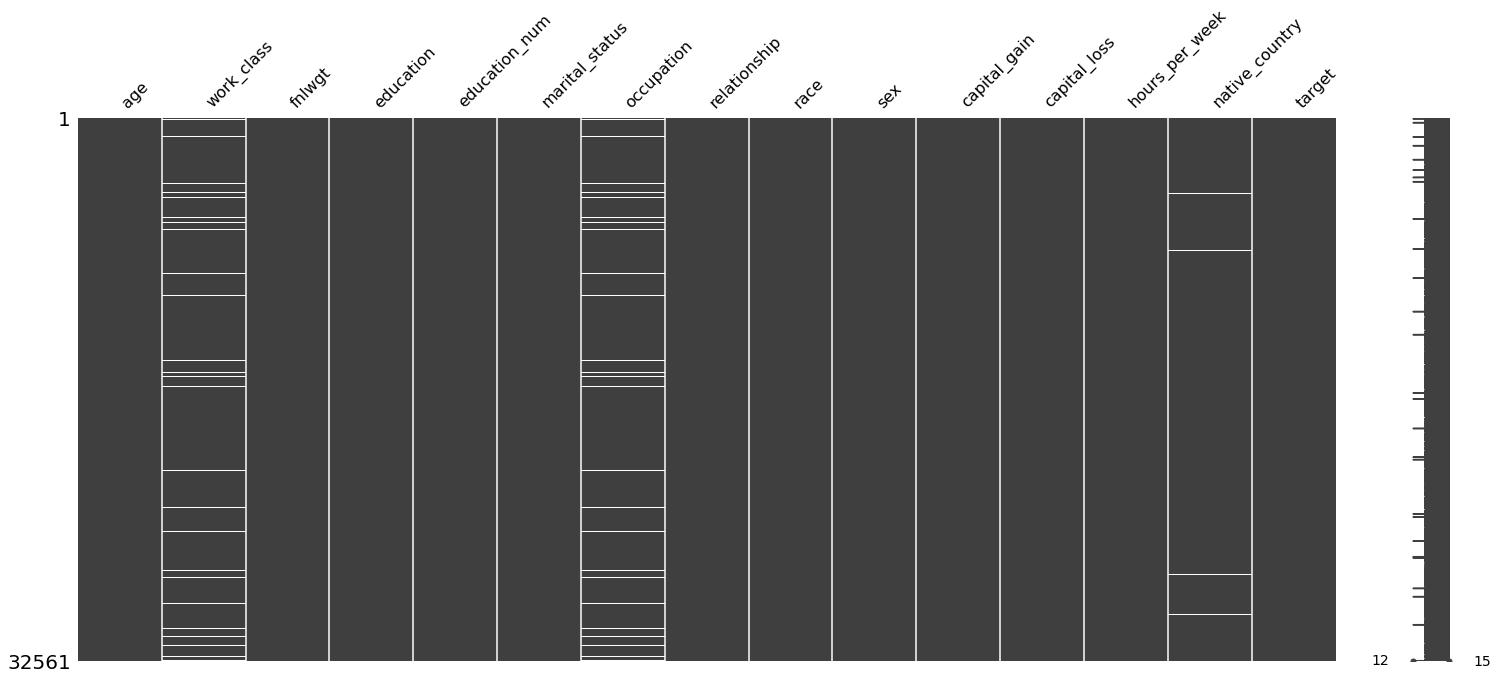

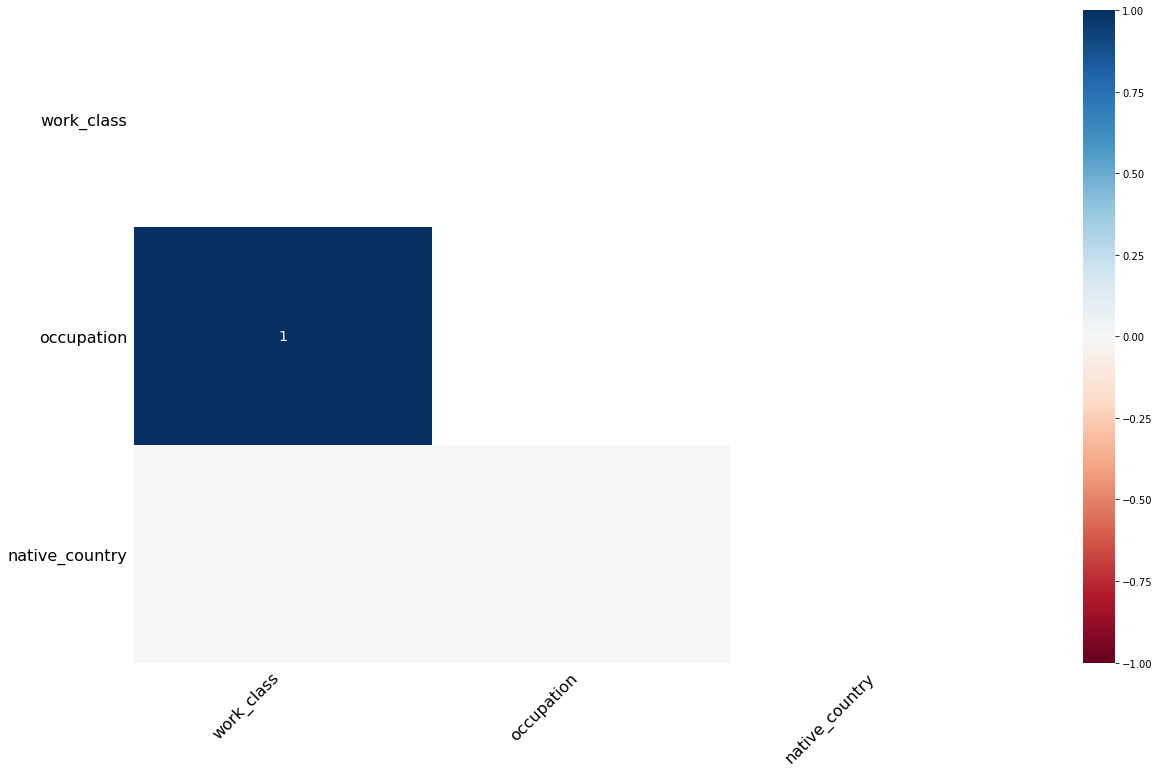

In [6]:
new_df = df.replace(to_replace='?', value=np.nan)
msno.matrix(new_df)
msno.heatmap(new_df)

We can see that the working class and occupation missing values have strong correlation. There are not missing at random at all.

In [7]:
a = df['work_class'].unique()
b = df['occupation'].unique()
print(a)
print(b)

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']


In [8]:
df.head()

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
cat_ix = df.select_dtypes(include=['object', 'bool']).columns
scaler = MinMaxScaler()

df[num_ix] = scaler.fit_transform(df[num_ix])
df.head()

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,0.301370,State-gov,0.044302,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States,<=50K
1,0.452055,Self-emp-not-inc,0.048238,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States,<=50K
2,0.287671,Private,0.138113,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States,<=50K
3,0.493151,Private,0.151068,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States,<=50K
4,0.150685,Private,0.221488,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba,<=50K


Because all the missing values are categorical data, we can use ordinal encoding to encode the remaining data, so we can later use that to find the missing values.

In [0]:
ordinal_enc_dict = {}

for col_name in cat_ix:
  ordinal_enc_dict[col_name] = OrdinalEncoder()

  col = df[col_name]
  col_not_null = col[col.notnull()]
  reshaped_vals = col_not_null.values.reshape(-1, 1)

  encoded_vals = ordinal_enc_dict[col_name].fit_transform(reshaped_vals)
  df.loc[col.notnull(), col_name] = np.squeeze(encoded_vals)

Because except for age, occupation and working class are missing systematiccally. Hence, it is better to impute missing categorical data using sophisticated imputer like KNNimputer.

In [0]:
df_KNN_imputed = df.copy(deep=True)

KNN_imputer = KNNImputer()

df_KNN_imputed.iloc[:, :] = np.round(KNN_imputer.fit_transform(df_KNN_imputed))

for col_name in cat_ix:
  reshaped = df_KNN_imputed[col_name].values.reshape(-1, 1)

  # df[col_name] = ordinal_enc_dict[col_name].inverse_transform(reshaped)
  # df[col_name] = scaler.fit_transform(reshaped)
  df[col_name] = reshaped

In [12]:
df.head()

,age,work_class,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,0.301370,7.0,0.044302,9.0,0.800000,4.0,1.0,1.0,4.0,1.0,0.02174,0.0,0.397959,39.0,0.0
1,0.452055,6.0,0.048238,9.0,0.800000,2.0,4.0,0.0,4.0,1.0,0.00000,0.0,0.122449,39.0,0.0
2,0.287671,4.0,0.138113,11.0,0.533333,0.0,6.0,1.0,4.0,1.0,0.00000,0.0,0.397959,39.0,0.0
3,0.493151,4.0,0.151068,1.0,0.400000,2.0,6.0,0.0,2.0,1.0,0.00000,0.0,0.397959,39.0,0.0
4,0.150685,4.0,0.221488,9.0,0.800000,2.0,10.0,5.0,2.0,0.0,0.00000,0.0,0.397959,5.0,0.0


Check to make sure that all the missing values are filled

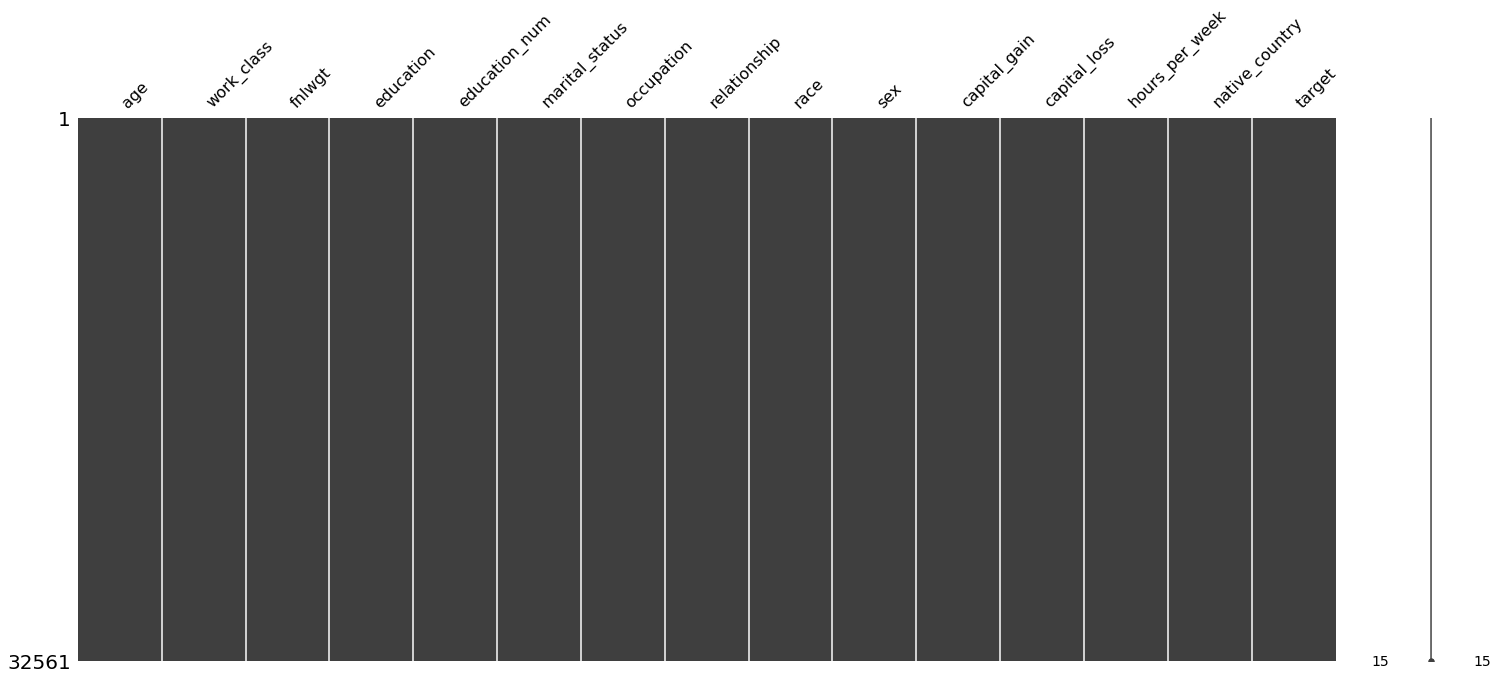

In [13]:
msno.matrix(df)

## Part 2: Train Test Validate Split

Ideally you will split the data and use the train data filling in proceedure for the test data. Because this is expensive you can do experiments initially to see if this matters. Just keep carefully in mind what you will know and what you can't know during the test evaluation. Both sklearn and tensorflow provide facilities for train test split. Take your pick.

At the end of this you should have a train, validate and test split. In the next part you are going to do preliminary testing of your model with your train+validation sets to get some idea of good canditates for hyperparameters. Later you will merge your training and validation set and resplit them up using cross validation to get better estimates for setting hyper-parameters

**NOTE: It is very important that you record very carefully any parameters you have for filling in data in step 1. For example if you you build a "fit" using some training data, later you will need to use the this "fit" to transform the data, you can not re-fit on new data. In other words if your "pipline" in training takes the mean of the input to fill in the first column, you need to fill with exactly that number, when you get new data for testing. Don't take the mean of the test data.**

Define dependent and independent Y, X data

In [0]:
Y = df.pop('target')
Y = LabelEncoder().fit_transform(Y)
X = df

Train, test, validation split

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

## Part 3: Build different 2 sklearn models and five different variations of Keras/tensorflow  models

Two simple models should be baseline from sklearn. Try a logistic regression and a random forest to know what your dense neural network should be able to beat. Use the training and validation data from above (don't look at the testing data). Try varations on the number of notes in a layer, the number of layers. Also play with feature selection. You can try to eliminate featuers and see if your validation score goes up or down. See how the batch size effects things.

### At the end of this section provide a report with figures on your conclusion on how these things effected preformance:

* number of hidden layers
* number of nodes per hidden layer aka matrix dimension
* activation function
* weight initialization
* metrics for evaluation
* batch size
* number of epochs
* optimizer
* also carry out feature selection / dimensionality reduction
* does the model do better or worse with dimensionality reduction?

** Note: do not try regularization yet!*


### **Baseline models**

#### **Logistic regression**

In [28]:
# instantiate
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_val)
print('Logistic regression %.2f' % (metrics.accuracy_score(Y_val, Y_pred) * 100))

LogReg 82.71


#### **Decision Tree Classifier**

In [29]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_val)
print('Decision tree classifier %s' % metrics.accuracy_score(Y_val, Y_pred))

Decision tree classifier 0.8166743436204514


### **Deep models**

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [0]:
def plot_loss_val(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [0]:
es = EarlyStopping(monitor='val_acc', mode='max', min_delta=0.001, patience=20, verbose=0)

#### **Model 1**

6513/6513 [==============================] - 0s 28us/sample - loss: 0.3363 - acc: 0.8380 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2273 - root_mean_squared_error: 0.3298 - categorical_accuracy: 1.0000


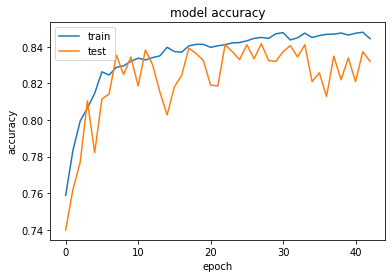

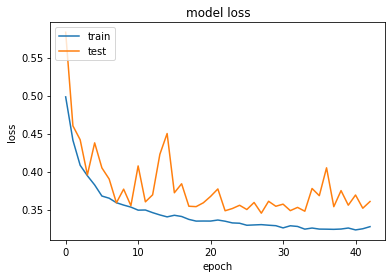

In [0]:
cvscores_1 = []
def get_compiled_model_1():
  model = Sequential([
    Dense(60, input_dim=14),
    Dense(30, activation='relu'),
    Dense(15, activation='relu'),
    # Dense(20, activation='relu'),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

keras.backend.clear_session()
model = get_compiled_model_1()
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=100, callbacks=[es], verbose=0)
scores = model.evaluate(X_val, Y_val)
plot_loss_val(history)

#### **Model 2 - Dimensionality reduction**

In [0]:
# define the number of features
ncol = X_train.shape[1]

Autoencoder for dimensionality reduction

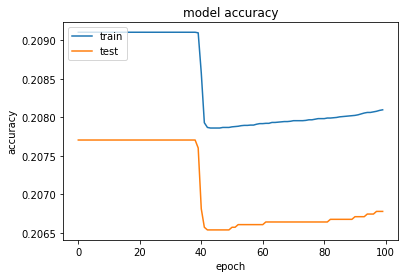

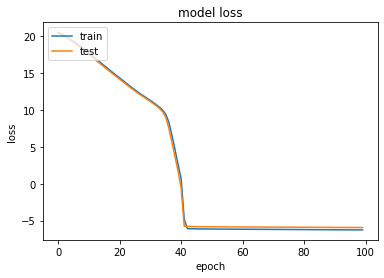

In [0]:
### Define the enoder dimension
encoding_dim = 12

keras.backend.clear_session()
input_dim = Input(shape = (ncol, ))

encoded1 = Dense(13, activation='relu')(input_dim)
encoded2 = Dense(12, activation='relu')(encoded1)
encoded3 = Dense(encoding_dim, activation='relu')(encoded2)

decoded1 = Dense(12, activation='relu')(encoded3)
decoded2 = Dense(13, activation='relu')(decoded1)
decoded3 = Dense(ncol, activation='softmax')(decoded2)
  
# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded3)
autoencoder.compile(optimizer='adadelta',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])


# autoencoder = get_compiled_model(ncol, encoding_dim)
history = autoencoder.fit(X_train, X_train, validation_split=0.1, batch_size=100, epochs=100, verbose=0)
# scores = model.evaluate(X_val, Y_val)
plot_loss_val(history)

6513/6513 [==============================] - 0s 29us/sample - loss: 0.5409 - acc: 0.7695 - mean_squared_error: 0.1800 - mean_absolute_error: 0.3822 - root_mean_squared_error: 0.4242 - categorical_accuracy: 1.0000


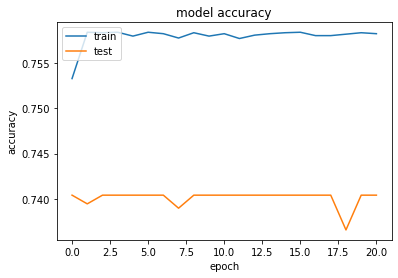

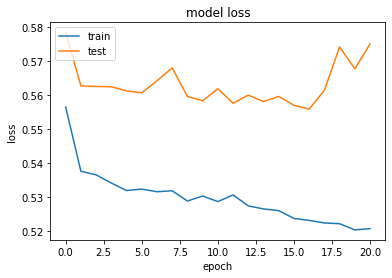

In [0]:
encoder = Model(inputs = input_dim, outputs = encoded3)
encoded_train = encoder.predict(X_train)
encoded_val = encoder.predict(X_val)
cvscores_2 = []
def get_compiled_model_2():
  model = Sequential([
    Dense(60, input_dim=encoding_dim),
    Dense(30, activation='relu'),
    Dense(15, activation='relu'),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

model = get_compiled_model_2()
history = model.fit(encoded_train, Y_train, validation_split=0.1, batch_size=30, epochs=100, callbacks=[es], verbose=0)
scores = model.evaluate(encoded_val, Y_val)
plot_loss_val(history)

#### **Model 3**

6513/6513 [==============================] - 0s 28us/sample - loss: 0.5377 - acc: 0.7717 - mean_squared_error: 0.1763 - mean_absolute_error: 0.3591 - root_mean_squared_error: 0.4199 - categorical_accuracy: 1.0000


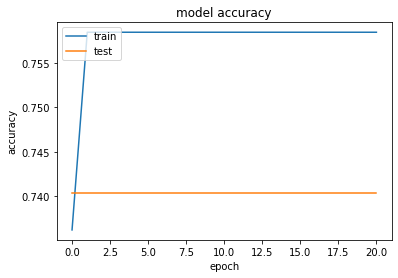

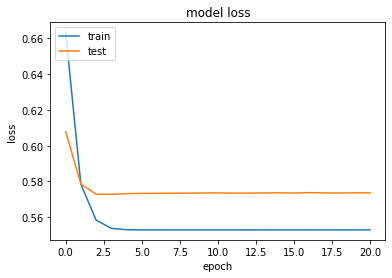

In [0]:
cvscores_3 = []
def get_compiled_model_3():
  model = Sequential([
    Dense(60, input_dim=14),
    Dense(30, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

keras.backend.clear_session()
model = get_compiled_model_3()
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=100, callbacks=[es], verbose=0)
scores = model.evaluate(X_val, Y_val)
plot_loss_val(history)

#### **Model 4**

6513/6513 [==============================] - 0s 28us/sample - loss: 0.5904 - acc: 0.7717 - mean_squared_error: 0.2017 - mean_absolute_error: 0.4363 - root_mean_squared_error: 0.4491 - categorical_accuracy: 1.0000


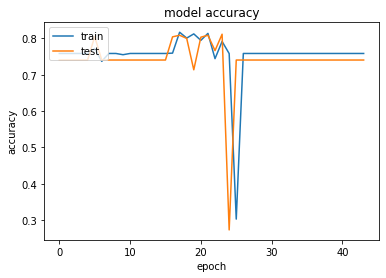

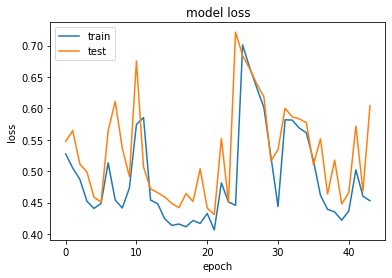

In [0]:
cvscores_4 = []
def get_compiled_model_4():
  model = Sequential([
    Dense(60, input_dim=14),
    Dense(30, activation='relu'),
    Dense(15, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='hard_sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

keras.backend.clear_session()
model = get_compiled_model_4()
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=100, callbacks=[es], verbose=0)
scores = model.evaluate(X_val, Y_val)
plot_loss_val(history)

#### **Model 5 - Simple dense network**

6513/6513 [==============================] - 0s 26us/sample - loss: 0.3348 - acc: 0.8386 - mean_squared_error: 0.1080 - mean_absolute_error: 0.2197 - root_mean_squared_error: 0.3286 - categorical_accuracy: 1.0000


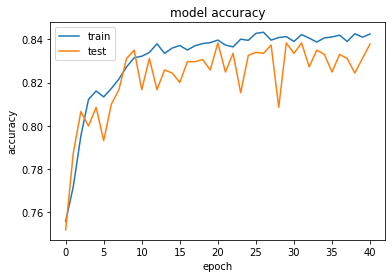

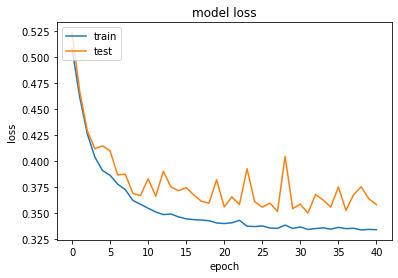

In [0]:
cvscores_5 = []
def get_compiled_model_5():
  model = Sequential([
    Dense(14, input_dim=14),
    Dense(14, activation='relu'),
    Dense(14, activation='relu'),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

keras.backend.clear_session()
model = get_compiled_model_5()
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=100, callbacks=[es], verbose=0)
scores = model.evaluate(X_val, Y_val)
plot_loss_val(history)

#### **Conclusion**

In model 2, using dimensionality reduction, even though more complicated than other models, yield the worst result. Model 3 and 4 shows that more complicated networks with more layers and more nodes per layer don't guarantee to give you better results compared to the baseline models and models with simpler architecture like models 1 and 5.

Interesting, in model 4, using a "non-traditional" activation function, there are great variances in the accuracy and loss for the first couple of epochs.

With the convergence of train and loss lines in models 1 and 5, it shows that with more epochs, overfitting can possibly be reduced and give more accurate results.

## **Part 4: Cross-validation**
We really should have used k-fold (eg. k=5) crossvalidation here, to not only evaluate our five keras/tensorflow models. See how your preliminary results change. Now that we have validation results with uncertainy (+- standard deviation), do your prior conclusion change. 

In [0]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [0]:
X_train = X_train.values
# Y_train = Y_train.values
X_val = X_val.values
# Y_val = Y_val.values
X_test = X_test.values
# Y_test = Y_test.values

### **Model 1**

In [0]:
for train, test in kfold.split(X_train, Y_train):
  keras.backend.clear_session()
  model = get_compiled_model_1()
  model.fit(X_train[train], Y_train[train], validation_split=0.1, batch_size=30, callbacks=[es], epochs=100, verbose=0)
  scores = model.evaluate(X_train[test], Y_train[test])
  cvscores_1.append(scores)

4167/4167 [==============================] - 0s 28us/sample - loss: 0.3313 - acc: 0.8495 - mean_squared_error: 0.1050 - mean_absolute_error: 0.2124 - root_mean_squared_error: 0.3241 - categorical_accuracy: 1.0000


In [0]:
score_mean = np.mean(cvscores_1, axis=0)
score_std = np.std(cvscores_1, axis=0)
for index in range(0, 6):
  print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))

loss: 33.58% (+/- 0.84%)
acc: 84.05% (+/- 0.60%)
mean_squared_error: 10.76% (+/- 0.30%)
mean_absolute_error: 21.00% (+/- 0.63%)
root_mean_squared_error: 32.80% (+/- 0.46%)
categorical_accuracy: 100.00% (+/- 0.00%)


### **Model 2**

In [0]:
for train, test in kfold.split(encoded_train, Y_train):
  keras.backend.clear_session()
  model = get_compiled_model_2()
  model.fit(encoded_train[train], Y_train[train], validation_split=0.1, batch_size=30, callbacks=[es], epochs=100, verbose=0)
  scores = model.evaluate(encoded_train[test], Y_train[test])
  cvscores_2.append(scores)

4167/4167 [==============================] - 0s 27us/sample - loss: 0.5257 - acc: 0.7562 - mean_squared_error: 0.1742 - mean_absolute_error: 0.3447 - root_mean_squared_error: 0.4174 - categorical_accuracy: 1.0000


In [0]:
score_mean = np.mean(cvscores_2, axis=0)
score_std = np.std(cvscores_2, axis=0)
for index in range(0, 6):
  print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))

loss: 52.52% (+/- 0.40%)
acc: 75.64% (+/- 0.02%)
mean_squared_error: 17.37% (+/- 0.15%)
mean_absolute_error: 35.07% (+/- 0.43%)
root_mean_squared_error: 41.67% (+/- 0.18%)
categorical_accuracy: 100.00% (+/- 0.00%)


### **Model 3**

In [0]:
for train, test in kfold.split(X_train, Y_train):
  keras.backend.clear_session()
  model = get_compiled_model_3()
  model.fit(X_train[train], Y_train[train], validation_split=0.1, batch_size=30, callbacks=[es], epochs=100, verbose=0)
  scores = model.evaluate(X_train[test], Y_train[test])
  cvscores_3.append(scores)

4167/4167 [==============================] - 0s 30us/sample - loss: 0.3324 - acc: 0.8493 - mean_squared_error: 0.1051 - mean_absolute_error: 0.2071 - root_mean_squared_error: 0.3241 - categorical_accuracy: 1.0000


In [0]:
score_mean = np.mean(cvscores_3, axis=0)
score_std = np.std(cvscores_3, axis=0)
for index in range(0, 6):
  print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))

loss: 42.68% (+/- 10.48%)
acc: 80.71% (+/- 4.15%)
mean_squared_error: 13.83% (+/- 3.75%)
mean_absolute_error: 27.28% (+/- 7.79%)
root_mean_squared_error: 36.86% (+/- 4.95%)
categorical_accuracy: 100.00% (+/- 0.00%)


### **Model 4**

In [0]:
for train, test in kfold.split(X_train, Y_train):
  keras.backend.clear_session()
  model = get_compiled_model_4()
  model.fit(X_train[train], Y_train[train], validation_split=0.1, batch_size=30, callbacks=[es], epochs=100, verbose=0)
  scores = model.evaluate(X_train[test], Y_train[test])
  cvscores_4.append(scores)

4167/4167 [==============================] - 0s 31us/sample - loss: 0.5549 - acc: 0.7567 - mean_squared_error: 0.1841 - mean_absolute_error: 0.3679 - root_mean_squared_error: 0.4291 - categorical_accuracy: 1.0000


In [0]:
score_mean = np.mean(cvscores_4, axis=0)
score_std = np.std(cvscores_4, axis=0)
for index in range(0, 6):
  print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))

loss: 51.64% (+/- 5.60%)
acc: 76.69% (+/- 2.04%)
mean_squared_error: 16.86% (+/- 2.14%)
mean_absolute_error: 32.59% (+/- 5.13%)
root_mean_squared_error: 40.97% (+/- 2.70%)
categorical_accuracy: 100.00% (+/- 0.00%)


### **Model 5**

In [0]:
for train, test in kfold.split(X_train, Y_train):
  keras.backend.clear_session()
  model = get_compiled_model_5()
  model.fit(X_train[train], Y_train[train], validation_split=0.1, batch_size=30, callbacks=[es], epochs=100, verbose=0)
  scores = model.evaluate(X_train[test], Y_train[test])
  cvscores_5.append(scores)

4167/4167 [==============================] - 0s 27us/sample - loss: 0.3644 - acc: 0.8138 - mean_squared_error: 0.1184 - mean_absolute_error: 0.2416 - root_mean_squared_error: 0.3442 - categorical_accuracy: 1.0000


In [0]:
score_mean = np.mean(cvscores_5, axis=0)
score_std = np.std(cvscores_5, axis=0)
for index in range(0, 6):
  print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))

loss: 34.12% (+/- 1.47%)
acc: 83.38% (+/- 1.02%)
mean_squared_error: 11.00% (+/- 0.51%)
mean_absolute_error: 21.76% (+/- 1.27%)
root_mean_squared_error: 33.15% (+/- 0.77%)
categorical_accuracy: 100.00% (+/- 0.00%)


### **Conclusion**

By looking at the cross-validation results, we can conclude several things

- Model 3, by having deep layers, the model yields really "unstable" results. The std of the metrics are highest among all the other models. The same goes for model 4, which has the same architecture overall, except for different activation function at the last layer. Its std of the metrics are higher than average.
- Model 2, by doing dimensionality reduction using a simple encoder, even though its accuracy is the lowest, the std of the accuracy is the lowest as well. This model yield "stable" results.
- Model 2,3,4, even with complicated steps and architectures, yield worse results than the baseline models.
- Model 1 and 5 has simple architectures. Even so, their accuracies are already higher than baseline machine learning models.

## **Part 5: Refining with Regularization**

We know that our biggest problem, if our models are flexibile enough, will be overfitting. Please try to regularize your best 2 models to see if you can improve their results. Look at these questions:

* Try regularizing each of your two best models, does the generalizability increase?  of Decrease?  
* Is one more sensitive than the other? Why might this happen and why?  
* Please try this with all of your features and then with the reduced set of features.  
* Report your precision, recall and f1 score on the train and validation sets (no cross validatio yet).  
* Next carry out cross validation.  Does regularization reduce under or overfitting?   Why or why not?  

** Hint: Try both L1 or L2 norm for regularization or dropout **


### **Model 4 with regularization**

In [0]:
cvscores_4 = []
def get_compiled_model_4():
  model = Sequential([
    Dense(60, input_dim=14, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(15, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

for train, test in kfold.split(X_train, Y_train):
  keras.backend.clear_session()
  model = get_compiled_model_4()
  model.fit(X_train[train], Y_train[train], validation_split=0.1, batch_size=30, callbacks=[es], epochs=100, verbose=0)
  scores = model.evaluate(X_train[test], Y_train[test])
  cvscores_4.append(scores)

In [0]:
score_mean = np.mean(cvscores_4, axis=0)
score_std = np.std(cvscores_4, axis=0)
for index in range(0, 6):
  print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))

loss: 45.12% (+/- 8.48%)
acc: 80.28% (+/- 3.78%)
mean_squared_error: 14.21% (+/- 3.44%)
mean_absolute_error: 29.44% (+/- 5.97%)
root_mean_squared_error: 37.43% (+/- 4.48%)
categorical_accuracy: 100.00% (+/- 0.00%)


### **Model 5 with regularization**

In [0]:
cvscores_5 = []
def get_compiled_model_5():
  model = Sequential([
    Dense(14, input_dim=14, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(14, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(14, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

for train, test in kfold.split(X_train, Y_train):
  keras.backend.clear_session()
  model = get_compiled_model_5()
  model.fit(X_train[train], Y_train[train], validation_split=0.1, batch_size=30, callbacks=[es], epochs=100, verbose=0)
  scores = model.evaluate(X_train[test], Y_train[test])
  cvscores_5.append(scores)

In [0]:
score_mean = np.mean(cvscores_5, axis=0)
score_std = np.std(cvscores_5, axis=0)
for index in range(0, 6):
  print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))


loss: 37.15% (+/- 1.31%)
acc: 83.18% (+/- 0.63%)
mean_squared_error: 11.38% (+/- 0.47%)
mean_absolute_error: 22.96% (+/- 0.61%)
root_mean_squared_error: 33.72% (+/- 0.69%)
categorical_accuracy: 100.00% (+/- 0.00%)


### **Conclusion**

Using regularization while keeping the same architecture of the network, there are improvements in model 4 and not much differences in model 5.

In model 4, there are several improvements. The loss, mae, mse, and rmse all go down, while the accuracy goes up. It means that by applying regularization, model's overfitting issue is mitigated. 

In model 5, none of the metrics has significant change. However, even with simpler architecture, model 5 still performs better than model 4 overall.

## Part 6: Grid Search

Please read this [article on using Grid Search CV with Keras](https://mlfromscratch.com/gridsearch-keras-sklearn). Be very very careful. Grid Search is very very slow. Given your above experiments you should have a pretty good idea of what your prameters should be before you run grid search. Run some small gridsearch runs (much smaller or more widely spaced) than you want to estimate time. Remember google colab will end after a limited amount of time so build slowly. Try to pin down the best parameters for:

1. The number of layers (please don't go deeper than 10 hidden layers)
2. The number of nodes per layer
3. The type of regularization to use
4. The type of weight initialization to use.
5. The type of activation function.
6. The metric to evaluate with, although logloss is standard, try using other metrics of accuracy.  

You may even try multiple and averaging or taking the harmonic weight of multiple metrics.

In [23]:
# Put your implementation here with graphs
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def get_compiled_model_5(optimizer='adam'):
  model = Sequential([
    Dense(14, input_dim=14, kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(14, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(14, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy', 'mse', 'mae', 'RootMeanSquaredError', 'categorical_accuracy'])
  return model

model = KerasClassifier(build_fn=get_compiled_model_5)
# optimizers = ['rmsprop', 'adam']
batches = np.array([100, 300])
param_grid = dict(batch_size=batches)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

14/14 [==============================] - 0s 2ms/step - loss: 0.6241 - accuracy: 0.7389 - mse: 0.1998 - mae: 0.4168 - root_mean_squared_error: 0.4470 - categorical_accuracy: 1.0000


RuntimeError: ignored

### Grid search conclusion

There seems to be a bug in Keras or Scikit-learn with Keras wrapper and gridsearchcv currently. I tried to search for the problem, but can't seem to fix it. I would try other grid search method given enough time. Sorry :<

## Overall Conclusion

Conclude with a full report here on what we know now about this problem. How well it does verses baseline, what the best Keras archtecture is, what features should be used, how the data should be cleaned etc.

The overall conclusion is that deep learning models can generally perform better than the baseline machine learning models. However, it takes a lot of efforts and time to fine-tune their hyperparameters and architectures in order to yield better results. Otherwise, the models may actually perform worse than the baseline models, in spite of being much more complicated. The best architectures for a quick guess into the data would be a simple dense network like model 5. No complicated regularization is needed for it to beat the baseline model. However, to get even better results, we can try to drop random columns from the input data, or try different methods to fill in the missing data. Based on the result from model 2, a better encoder can potentially increase the accuracy of the model. However, lots of hyperparameters tunning would be needed.